### Piotr Klimczak 239533 / 215275, 1SIiUM2
### SI Lab2

In [1]:
import vrep 
import sys
import time 
import numpy as np
import skfuzzy as fuzz 
import matplotlib.pyplot as plt 
from skfuzzy import control as ctrl 

### Zmienne we/wy dla skfuzzy

In [2]:
odleglosc = ctrl.Antecedent(np.arange(-1.4, 1.4, 0.1), 'odleglosc') #zmierzona odleglosc
wychylenie = ctrl.Antecedent(np.arange(0.0, 0.31, 0.01), 'wychylenie')
#zalezne od predkosci, ustawilem na sztywno 4.5, wyprintowalem: 
#abs (position_cuboid[0] - position_load[0])
#znalazlem max, znalazlem min, odjalem od siebie, wyszło 0.31
predkosc  = ctrl.Consequent(np.arange(-4.5, 4.5, 0.01), 'predkosc') #predkosc na kolach, też 4.5

predkosc.automf(5) #5 stopni predkosci

odleglosc['za_celem'] = fuzz.trapmf(odleglosc.universe, [-1.4, -1.4, -1.2, 0]) 
odleglosc['przed_celem'] = fuzz.trapmf(odleglosc.universe, [0, 1.2, 1.4,1.4]) 
odleglosc['w_punkt'] = fuzz.trimf(odleglosc.universe, [-0.65, 0, 0.65]) 

wychylenie['duze'] = fuzz.trapmf(wychylenie.universe, [0.08, 0.23, 0.31, 0.31]) #trapezy
wychylenie['male'] = fuzz.trapmf(wychylenie.universe, [0.0, 0.0, 0.08, 0.23])

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


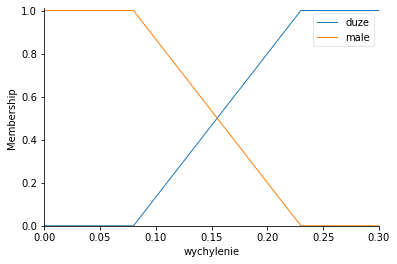

In [3]:
wychylenie.view()

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


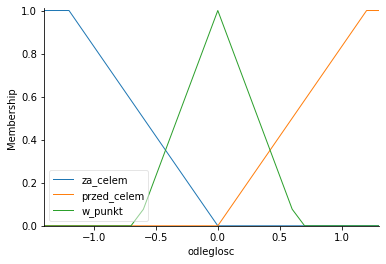

In [4]:
odleglosc.view()

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


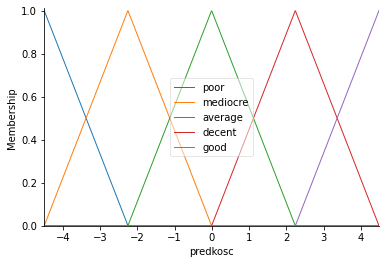

In [5]:
predkosc.view()

### Reguły logiki rozmytej

In [6]:
rule1 = ctrl.Rule(odleglosc['przed_celem'] & wychylenie['male'], predkosc['good']) #pelna predkosc
rule2 = ctrl.Rule(odleglosc['przed_celem'] & wychylenie['duze'], predkosc['decent']) #50%
rule3 = ctrl.Rule(odleglosc['w_punkt'], predkosc['average']) #0%
rule4 = ctrl.Rule(odleglosc['za_celem'] & wychylenie['duze'], predkosc['mediocre']) #50%
rule5 = ctrl.Rule(odleglosc['za_celem'] & wychylenie['male'], predkosc['poor']) #pelna predkosc

speed_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5])
speeding = ctrl.ControlSystemSimulation(speed_ctrl)

### Łączenie

In [7]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

# get handles to robot drivers
err_code, lf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LF", vrep.simx_opmode_blocking)
err_code, lb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LB", vrep.simx_opmode_blocking)
err_code, rb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RB", vrep.simx_opmode_blocking)
err_code, rf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RF", vrep.simx_opmode_blocking)


Connected to remote API server


### Pętla while

In [8]:
# get handle to the load
err_code, load_handle = vrep.simxGetObjectHandle(clientID, "Load", vrep.simx_opmode_blocking)
err_code2, cuboid_handle = vrep.simxGetObjectHandle(clientID, "Cuboid", vrep.simx_opmode_blocking)

#get first position of load
err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_streaming)
err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_streaming)

#get positions of load
t = time.time()
while (time.time()-t) < 25:
    err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_buffer)
    err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_buffer)
    if err_code==0:
        
        speeding.input['odleglosc']  = position_cuboid[0]
        speeding.input['wychylenie'] = abs(position_cuboid[0] - position_load[0])
        speeding.compute()
        velocity = speeding.output['predkosc']
                
        err_code = vrep.simxSetJointTargetVelocity(clientID,lb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,lf_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rf_motor_handle,velocity,vrep.simx_opmode_streaming) 
        
        print("Pozycja wózka: ",position_cuboid[0])
        print("Prędkość wózka: ",velocity)
        #Testowanie wychylenia poniżej:
        #print(abs (position_cuboid[0] - position_load[0]))
        

Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.400026559829712
Prędkość wózka:  3.7408277778050985
Pozycja wózka:  1.40

Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2739818096160889
Prędkość wózka:  2.7649263194059954
Pozycja wózka:  1.2548400163650513
Prędkość wózka:  2.5461729740852705
Pozycja wózka:  1.2548400163650513
Prędkość wózka:  2.5461729740852705
Pozycja wózka:  1.2548400163650513
Prędkość wózka:  2.5461729740852705
Pozycj

Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.100294589996338
Prędkość wózka:  3.7360525773256565
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka:  1.0783555507659912
Prędkość wózka:  3.7338379076041046
Pozycja wózka

Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycja wózka:  0.9417837262153625
Prędkość wózka:  2.2918786925258385
Pozycj

Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.8384090662002563
Prędkość wózka:  3.688555933588468
Pozycja wózka:  0.83

Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6943663358688354
Prędkość wózka:  2.63800144954598
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777414679527283
Prędkość wózka:  2.5507843300111306
Pozycja wózka:  0.6777

Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.590146541595459
Prędkość wózka:  2.327992177984927
Pozycja wózka:  0.5763160586357117
Prędkość wózka:  2.2724950613221377
Pozycja wózka:  0.5763160586357117
Prędkość wózka:  2.2724950613221377
Pozycja wózka:  0.5763160586357117
Prędkość wózka:  2.2724950613221377
Pozycja wózka:  0.5763160586357117
Prędkość wózka:  2.2724950613221377
Pozycja wózka:  0.57631605

Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.5021306872367859
Prędkość wózka:  1.6111573037366302
Pozycja wózka:  0.4920492172241211
Prędkość wózka:  1.5713514239380184
Pozycja wózka:  0.4920492172241211
Prędkość wózka:  1.5713514239380184
Pozycja wózka:  0.4920492172241211
Prędkość wózka:  1.5713514239380184
Pozycja wózka:  0.4920492172241211
Prędkość wózka:  1.5713514239380184
Pozycja wózka:  0.4920492172241211
Prędkość wózka:  1.5713514239380184
Pozycj

Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.1801799709444225
Pozycja wózka:  0.43787795305252075
Prędkość wózka:  1.180179970

Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.402895987033844
Prędkość wózka:  1.2296152381353804
Pozycja wózka:  0.40

Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.3442907929420471
Prędkość wózka:  0.8720038297475617
Pozycja wózka:  0.33853307366371155
Prędkość wózka:  0.8477581647315096
Pozycja wózka:  0.33853307366371155
Prędkość wózka:  0.8477581647315096
Pozycja wózka:  0.33853307366371155
Prędkość wózka:  0.8477581647315096
Pozycja wózka:  0.33853307366371155
Prędkość wózka:  0.8477581647315096
Po

Pozycja wózka:  0.3128935992717743
Prędkość wózka:  0.8875467035469298
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.30751878023147583
Prędkość wózka:  0.8124776787230409
Pozycja wózka:  0.3021121919155121
Prędkość wózka:  0.7634371059096319
Pozycja wózka:  0.3021121919155121
Prędkość wózka:  0.7634371059096319
Pozycja wózka:  0.3021121919155121
Prędkość wózka:  0.7634371059096319
Pozycja wózka:  0.3021121919155121
Prędkość wózka:  0.76343710590963

Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.7028154699878911
Pozycja wózka:  0.27872544527053833
Prędkość wózka:  0.702815469

Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.2480916678905487
Prędkość wózka:  0.6802150928722226
Pozycja wózka:  0.24384641647338867
Prędkość wózka:  0.6674238804037501
Pozycja wózka:  0.24384641647338867
Prędkość wózka:  0.6674238804037501
Pozycja wózka:  0.24384641647338867
Prędkość wózka:  0.6674238804037501
Poz

Pozycja wózka:  0.2239404171705246
Prędkość wózka:  0.6002039281105453
Pozycja wózka:  0.2239404171705246
Prędkość wózka:  0.6002039281105453
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5786503688479132
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.5448511906677993
Pozycja wózka:  0.22016820311546326
Prędkość wózka:  0.54485119066

Pozycja wózka:  0.2005489617586136
Prędkość wózka:  0.5411426506132352
Pozycja wózka:  0.2005489617586136
Prędkość wózka:  0.5411426506132352
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.5319027889934121
Pozycja wózka:  0.19728930294513702
Prędkość wózka:  0.53190278899

Pozycja wózka:  0.17911586165428162
Prędkość wózka:  0.4809455225818592
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka:  0.47324748098477437
Pozycja wózka:  0.17634344100952148
Prędkość wózka: 

Pozycja wózka:  0.15983839333057404
Prędkość wózka:  0.39962322589979016
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15738652646541595
Prędkość wózka:  0.421074323717941
Pozycja wózka:  0.15497350692749023
Prędkość wózka:  0.41448488477537815
Pozycja wózka:  0.15497350692749023
Prędkość wózka:  0.41448488477537815
Pozycja wózka:  0.15497350692749023
Prędkość wózka:  0.41448488477537815
Pozycja wózka:  0.15497350692749023
Prędkość wózka:  0.41448488477537

Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.14029714465141296
Prędkość wózka:  0.3746133049500227
Pozycja wózka:  0.13798178732395172
Prędkość wózka:  0.368355773

Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.31345434736485683
Pozycja wózka:  0.1248294860124588
Prędkość wózka:  0.3134543473

Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.1117345467209816
Prędkość wózka:  0.2977852228217793
Pozycja wózka:  0.10988038778305054
Prędkość wózka:  0.29282050341909527
Pozycja wózka:  0.10988038778305054
Prędkość wózka:  0.29282050341909527
Pozycja wózka:  0.10988038778305054
Prędkość wózka:  0.29282050341909527


Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09938368946313858
Prędkość wózka:  0.26474155767192586
Pozycja wózka:  0.09771637618541718
Prędkość wózka:

Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:  0.23250435825418744
Pozycja wózka:  0.08732414245605469
Prędkość wózka:

Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.0792664885520935
Prędkość wózka:  0.2109596927452294
Pozycja wózka:  0.07804757356643677
Prędkość wózka:  0.20769816075715783
Pozycja wózka:  0.07804757356643677
Prędkość wózka:  0.20769816075715783
Po

Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.07080089300870895
Prędkość wózka:  0.18145628137179057
Pozycja wózka:  0.06969129294157028
Prędkość wózka:

Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:  0.16506618400766299
Pozycja wózka:  0.06214373558759689
Prędkość wózka:

Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.056410204619169235
Prędkość wózka:  0.14964575097996097
Pozycja wózka:  0.055537909269332886
Prędkość wózka:  0.14297618156010047
Pozycja wózka:  0.055537909269332886
Prędkość wózka:  0.14297618156010047
Pozycja wózka:  0.055537909269332886
P

Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
Prędkość wózka:  0.13381954639085342
Pozycja wózka:  0.050539977848529816
P

Pozycja wózka:  0.045139867812395096
Prędkość wózka:  0.11922225352583576
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
Prędkość wózka:  0.11749252813446556
Pozycja wózka:  0.044501595199108124
P

Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.040347710251808167
Prędkość wózka:  0.10389064328305404
Pozycja wózka:  0.039771903306245804
P

Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.036062709987163544
Prędkość wózka:  0.0945879330141137
Pozycja wózka:  0.035493433475494385
Prędkość wózka

Pozycja wózka:  0.032757751643657684
Prędkość wózka:  0.08558000269105537
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092356709142
Pozycja wózka:  0.0322396345436573
Prędkość wózka:  0.08265092

Pozycja wózka:  0.029411589726805687
Prędkość wózka:  0.07644354409896091
Pozycja wózka:  0.029411589726805687
Prędkość wózka:  0.07644354409896091
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028888657689094543
Prędkość wózka:  0.07501226696873546
Pozycja wózka:  0.028522763401269913
Prędkość wózka:  0.07401024119746716
Pozycja wózka:  0.028522763401269913
Prędkość wózka:  0.07401024119746716
Pozycja wózka:  0.028522763401269913
P

Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:  0.06677729299578815
Pozycja wózka:  0.02588067576289177
Prędkość wózka:

Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:  0.05862714973253441
Pozycja wózka:  0.02320210635662079
Prędkość wózka:

Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020928751677274704
Prędkość wózka:  0.05317384311122218
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
Prędkość wózka:  0.05240518188461887
Pozycja wózka:  0.020649421960115433
P

Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01871042512357235
Prędkość wózka:  0.04706122742581523
Pozycja wózka:  0.01835930533707142
Prędkość wózka:  0.04558996948435974
Pozycja wózka:  0.01835930533707142
Prędkość wózka:  0.04558996948435974
Pozycja wózka:  0.01835930533707142
Prędkość wózka:  0.04558996948435974
Pozycja wózka:  0.01835930533707142
Prędkość wózka:  0.04558996948435974
Pozycja wózka:  0.01835930533707142
Prędkość wózka:  0.04558996948435974
Pozycja wózka:  0.01835930533707142
Prędkość wózka:

Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.016769539564847946
Prędkość wózka:  0.041702071659724844
Pozycja wózka:  0.0167695

Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.015147285535931587
Prędkość wózka:  0.03722030421338968
Pozycja wózka:  0.014867493882775307
Prędkość wózka:  0.03644626543692432
Pozycja wózka:  0.014867493882775307
P

Pozycja wózka:  0.01383175142109394
Prędkość wózka:  0.03329118457762528
Pozycja wózka:  0.01383175142109394
Prędkość wózka:  0.03329118457762528
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prędkość wózka:  0.03274468699533947
Pozycja wózka:  0.013631504960358143
Prę

Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka:  0.0304770911478453
Pozycja wózka:  0.012713667936623096
Prędkość wózka

Pozycja wózka:  0.011652931571006775
Prędkość wózka:  0.02753321327245417
Pozycja wózka:  0.011652931571006775
Prędkość wózka:  0.02753321327245417
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
Prędkość wózka:  0.02704828944668305
Pozycja wózka:  0.011478031054139137
P

Pozycja wózka:  0.010596753098070621
Prędkość wózka:  0.02443541358118263
Pozycja wózka:  0.010596753098070621
Prędkość wózka:  0.02443541358118263
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózka:  0.02417837744844144
Pozycja wózka:  0.01044386439025402
Prędkość wózk

Pozycja wózka:  0.009617859497666359
Prędkość wózka:  0.021882897790669598
Pozycja wózka:  0.009617859497666359
Prędkość wózka:  0.021882897790669598
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009464642032980919
Prędkość wózka:  0.021456785707242777
Pozycja wózka:  0.009358573704957962
Prędkość wózka:  0.021161741147993286
Pozycja wózka:  0.0093585

Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
Prędkość wózka:  0.01908881083902598
Pozycja wózka:  0.008653945289552212
P

Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.007864957675337791
Prędkość wózka:  0.017001901724556713
Pozycja wózka:  0.0078649

Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
Prędkość wózka:  0.01551579239599375
Pozycja wózka:  0.007332199718803167
P

Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózka:  0.0066688768565654755
Prędkość wózka:  0.013603534121878367
Pozycja wózk

Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
Prędkość wózka:  0.01222148371998142
Pozycja wózka:  0.006151272915303707
P

Pozycja wózka:  0.005767598282545805
Prędkość wózka:  0.011105475816021127
Pozycja wózka:  0.005767598282545805
Prędkość wózka:  0.011105475816021127
Pozycja wózka:  0.005767598282545805
Prędkość wózka:  0.011105475816021127
Pozycja wózka:  0.005767598282545805
Prędkość wózka:  0.011105475816021127
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.005698493216186762
Prędkość wózka:  0.010913741102419546
Pozycja wózka:  0.0056984

Pozycja wózka:  0.005480512510985136
Prędkość wózka:  0.01035065975669867
Pozycja wózka:  0.005480512510985136
Prędkość wózka:  0.01035065975669867
Pozycja wózka:  0.005480512510985136
Prędkość wózka:  0.01035065975669867
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.0053599984385073185
Prędkość wózka:  0.01001432211852858
Pozycja wózka:  0.005183987319469452
Prędkość wózka:  0.009522984353057788
Pozycja wózka:  0.0051839873

Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.004882204346358776
Prędkość wózka:  0.008680231969041868
Pozycja wózka:  0.0048822

Pozycja wózka:  0.0045952387154102325
Prędkość wózka:  0.007848885175546017
Pozycja wózka:  0.0045952387154102325
Prędkość wózka:  0.007848885175546017
Pozycja wózka:  0.0045952387154102325
Prędkość wózka:  0.007848885175546017
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007787517318561221
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.004573174752295017
Prędkość wózka:  0.007816821970115802
Pozycja wózka:  0.0045

Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.004312597215175629
Prędkość wózka:  0.007088452065335132
Pozycja wózka:  0.0043125

Pozycja wózka:  0.004085433203727007
Prędkość wózka:  0.006430188104041718
Pozycja wózka:  0.004085433203727007
Prędkość wózka:  0.006430188104041718
Pozycja wózka:  0.004085433203727007
Prędkość wózka:  0.006430188104041718
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.0040525104850530624
Prędkość wózka:  0.0063385165681649
Pozycja wózka:  0.00405251048505306

Pozycja wózka:  0.0038710483349859715
Prędkość wózka:  0.005853532438003814
Pozycja wózka:  0.0038710483349859715
Prędkość wózka:  0.005853532438003814
Pozycja wózka:  0.0038710483349859715
Prędkość wózka:  0.005853532438003814
Pozycja wózka:  0.0038710483349859715
Prędkość wózka:  0.005853532438003814
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Pozycja wózka:  0.0038237241096794605
Prędkość wózka:  0.0057211244075652855
Poz

Pozycja wózka:  0.00367432227358222
Prędkość wózka:  0.005303047994292145
Pozycja wózka:  0.00367432227358222
Prędkość wózka:  0.005303047994292145
Pozycja wózka:  0.00367432227358222
Prędkość wózka:  0.005303047994292145
Pozycja wózka:  0.00367432227358222
Prędkość wózka:  0.005303047994292145
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.0036335638724267483
Prędkość wózka:  0.005188974816723705
Pozycja wózka:  0.00

Pozycja wózka:  0.00348842260427773
Prędkość wózka:  0.004766050035229627
Pozycja wózka:  0.00348842260427773
Prędkość wózka:  0.004766050035229627
Pozycja wózka:  0.00348842260427773
Prędkość wózka:  0.004766050035229627
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.0034541890490800142
Prędkość wózka:  0.004686857549746122
Pozycja wózka:  0.

Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózka:  0.0033264600206166506
Prędkość wózka:  0.004329221578357759
Pozycja wózk

Pozycja wózka:  0.0031876820139586926
Prędkość wózka:  0.003926810131038077
Pozycja wózka:  0.0031876820139586926
Prędkość wózka:  0.003926810131038077
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.003160773543640971
Prędkość wózka:  0.003851690989300352
Pozycja wózka:  0.00316

Pozycja wózka:  0.0030600535683333874
Prędkość wózka:  0.0035830562248280722
Pozycja wózka:  0.0030600535683333874
Prędkość wózka:  0.0035830562248280722
Pozycja wózka:  0.0030600535683333874
Prędkość wózka:  0.0035830562248280722
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034
Pozycja wózka:  0.0030440210830420256
Prędkość wózka:  0.0035381412926509034

Pozycja wózka:  0.0029593422077596188
Prędkość wózka:  0.003300894405927968
Pozycja wózka:  0.0029593422077596188
Prędkość wózka:  0.003300894405927968
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
Pozycja wózka:  0.0029562576673924923
Prędkość wózka:  0.0032922517567935713
P

Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054
Pozycja wózka:  0.0028495308943092823
Prędkość wózka:  0.0029824626350362054

Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.002747389953583479
Prędkość wózka:  0.002706919260088403
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wózka:  0.0027424697764217854
Prędkość wózka:  0.0026931285172787558
Pozycja wóz

Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.0026672501116991043
Prędkość wózka:  0.0024730981142096673
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycja wózka:  0.002641483210027218
Prędkość wózka:  0.0024010775036869296
Pozycj

Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.0026141724083572626
Prędkość wózka:  0.0023334853409365365
Pozycja wózka:  0.002580446656793356
Prędkość wózka:  0.0022389328229297117
Pozycja wózka:  0.002580446656793356
Prędkość wózka:  0.0022389328229297117
Pozycja wózka:  0.002580446656793356
Prędkość wózka:  0.0022389328229297117
Pozycja wózka:  0.002580446656793356
Prę

Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025244576390832663
Prędkość wózka:  0.002081952178346925
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózka:  0.0025311033241450787
Prędkość wózka:  0.002100585938847572
Pozycja wózk

Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.00245869904756546
Prędkość wózka:  0.0018900546599709635
Pozycja wózka:  0.0024586

Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023889518342912197
Prędkość wózka:  0.0017019648799500781
Pozycja wózka:  0.0023760395124554634
Prędkość wózka:  0.0016657515721106315
Pozycja wózka:  0.0023760395124554634
Prędkość wózka:  0.0016657515721106315
Pozycja wózka:  0.0023760395124554634
Prędkość wózka:  0.0016657515721106315
Pozycja wózka:  0.0023760395124554634
Prędkość wózka:  0.0016657515721106315
Pozycja wózka:  0.0023760395124554634
Prędkość wózka:  0.0016657515721106315

Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózka:  0.002349482150748372
Prędkość wózka:  0.0015846035440621159
Pozycja wózk

Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821
Pozycja wózka:  0.0022984244860708714
Prędkość wózka:  0.0014480598995449821

Pozycja wózka:  0.0022766771726310253
Prędkość wózka:  0.0013870589039941396
Pozycja wózka:  0.0022766771726310253
Prędkość wózka:  0.0013870589039941396
Pozycja wózka:  0.0022766771726310253
Prędkość wózka:  0.0013870589039941396
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja wózka:  0.002254271414130926
Prędkość wózka:  0.0013242087056189549
Pozycja w

Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.002253801329061389
Prędkość wózka:  0.001316944314999009
Pozycja wózka:  0.0022538

Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.0022208201698958874
Prędkość wózka:  0.0012303706206064366
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycja wózka:  0.002210994716733694
Prędkość wózka:  0.0012028070904381962
Pozycj

Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózka:  0.002172645181417465
Prędkość wózka:  0.0010898690590012206
Pozycja wózk

Pozycja wózka:  0.0021482412703335285
Prędkość wózka:  0.0010267531912691787
Pozycja wózka:  0.0021482412703335285
Prędkość wózka:  0.0010267531912691787
Pozycja wózka:  0.0021482412703335285
Prędkość wózka:  0.0010267531912691787
Pozycja wózka:  0.0021482412703335285
Prędkość wózka:  0.0010267531912691787
Pozycja wózka:  0.0021482412703335285
Prędkość wózka:  0.0010267531912691787
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117
Pozycja wózka:  0.0021311533637344837
Prędkość wózka:  0.0009788101769870117

Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózka:  0.002258183667436242
Prędkość wózka:  0.0013351830994712218
Pozycja wózk

Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783
Pozycja wózka:  0.0020992292556911707
Prędkość wózka:  0.0008892380904236783

Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózka:  0.0020515695214271545
Prędkość wózka:  0.000755506542639809
Pozycja wózk

Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózka:  0.002063622698187828
Prędkość wózka:  0.0007847548333887341
Pozycja wózk

Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.00204436550848186
Prędkość wózka:  0.0007352914247562711
Pozycja wózka:  0.0020443

Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.002035338431596756
Prędkość wózka:  0.0007099602858250375
Pozycja wózka:  0.0020272298716008663
Prędkość wózka:  0.0006872063036118616
Pozycja wózka:  0.0020272298716008663
Prędkość wózka:  0.0006872063036118616
Pozycja wó

Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002099761739373207
Prędkość wózka:  0.0008907321619790374
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.002165284939110279
Prędkość wózka:  0.001074570751502394
Pozycja wózka:  0.

Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.0020169310737401247
Prędkość wózka:  0.0006583057094136729
Pozycja wózka:  0.001992391888052225
Prędkość wózka:  0.0005894416217353233
Pozycja wózka:  0.001992391888052225
Prędkość wózka:  0.0005894416217353233
P

Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019836353603750467
Prędkość wózka:  0.0005608491670849999
Pozycja wózka:  0.0019560898654162884
Prędkość wózka:  0.0004837322082984612
Pozycja wózka:  0.0019560898654162884
Prędkość wózka:  0.0004837322082984612
Pozycja wózka:  0.0019560898654162884
Prędkość wózka:  0.0004837322082984612
Pozycja wózka:  0.0019560898654162884
Prędkość wózka:  0.0004837322082984612
Pozycja wózka:  0.0019560898654162884
Prędkość wózka:  0.0004837322082984612

Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279
Pozycja wózka:  0.0019730417989194393
Prędkość wózka:  0.0005351376915286279

Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.001953642349690199
Prędkość wózka:  0.0004768798465685942
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozycja wózka:  0.0019639423117041588
Prędkość wózka:  0.0005057165997973091
Pozyc

Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Prędkość wózka:  0.000513720920208201
Pozycja wózka:  0.00196541054174304
Pr

Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594
Pozycja wózka:  0.0019623208791017532
Prędkość wózka:  0.0005050498481937594

Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.001965252449735999
Prędkość wózka:  0.0005132772394447754
Pozycja wózka:  0.0019880146719515324
Prędkość wózka:  0.0005771575895949792
Pozycja wózka:  0.0019880146719515324
Prędkość wózka:  0.0005771575895949792
Pozycja wózka:  0.0019880146719515324
Prędkość wózka:  0.0005771575895949792
Pozycja w

Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758
Pozycja wózka:  0.0019909904804080725
Prędkość wózka:  0.0005814398651943758

Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózka:  0.001964900176972151
Prędkość wózka:  0.0005122885954445082
Pozycja wózk

Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.0019874698482453823
Prędkość wózka:  0.0005756286134612268
Pozycja wózka:  0.001955390442162752
Prędkość wózka:  0.0004855995654129665
Pozycja wózka:  0.001955390442162752
Prędkość wózka:  0.0004855995654129665
P

Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.0005713401042929351
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wózka:  0.0019873827695846558
Prędkość wózka:  0.000575384238516562
Pozycja wóz

Pozycja wózka:  0.00194414088036865
Prędkość wózka:  0.0004540271803652843
Pozycja wózka:  0.00194414088036865
Prędkość wózka:  0.0004540271803652843
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:  0.001972648547962308
Prędkość wózka:  0.0005340340574103551
Pozycja wózka:

Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789
Pozycja wózka:  0.0019596104975789785
Prędkość wózka:  0.0004935889269967789

Pozycja wózka:  0.0019806716591119766
Prędkość wózka:  0.0005565502740685552
Pozycja wózka:  0.0019806716591119766
Prędkość wózka:  0.0005565502740685552
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.00196331599727273
Prędkość wózka:  0.0005078426308242102
Pozycja wózka:  0.001

Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019528170814737678
Prędkość wózka:  0.00047456931664070697
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265509368
Pozycja wózka:  0.0019901408813893795
Prędkość wózka:  0.0005790614265

Pozycja wózka:  0.0019579813815653324
Prędkość wózka:  0.0004928710670522044
Pozycja wózka:  0.0019579813815653324
Prędkość wózka:  0.0004928710670522044
Pozycja wózka:  0.0019579813815653324
Prędkość wózka:  0.0004928710670522044
Pozycja wózka:  0.0019579813815653324
Prędkość wózka:  0.0004928710670522044
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja wózka:  0.001967700896784663
Prędkość wózka:  0.0005201487241819156
Pozycja 

Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354
Pozycja wózka:  0.0019624303095042706
Prędkość wózka:  0.0005053569630254354

Pozycja wózka:  0.0019621814135462046
Prędkość wózka:  0.0005007866718631942
Pozycja wózka:  0.0019621814135462046
Prędkość wózka:  0.0005007866718631942
Pozycja wózka:  0.0019621814135462046
Prędkość wózka:  0.0005007866718631942
Pozycja wózka:  0.0019621814135462046
Prędkość wózka:  0.0005007866718631942
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja wózka:  0.001981978304684162
Prędkość wózka:  0.0005562101810971346
Pozycja 

Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.001984748523682356
Prędkość wózka:  0.000567991553225734
Pozycja wózka:  0.0019806846976280212
Prędkość wózka:  0.0005565868653746485
Pozycja wózka:  0.0019806846976280212
Prędkość wózka:  0.0005565868653746485
Pozycja wózka:  0.001

Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0019944419618695974
Prędkość wózka:  0.0005911021820780845
Pozycja wózka:  0.0020119177643209696
Prędkość wózka:  0.0006400239409029918
Pozycja wózka:  0.0020119177643209696
Prędkość wózka:  0.0006400239409029918
Pozycja wózka:  0.0020119177643209696
Prędkość wózka:  0.0006400239409029918

Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.001990753458812833
Prędkość wózka:  0.0005848436142943853
Pozycja wózka:  0.0020023020915687084
Prędkość wózka:  0.000617252867159577
Pozycja wózk

Pozycja wózka:  0.001966699492186308
Prędkość wózka:  0.0005134357447410152
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469
Pozycja wózka:  0.0019844407215714455
Prędkość wózka:  0.0005631037976306469


Pozycja wózka:  0.0019662557169795036
Prędkość wózka:  0.0005160928787426123
Pozycja wózka:  0.0019662557169795036
Prędkość wózka:  0.0005160928787426123
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wózka:  0.001967593329027295
Prędkość wózka:  0.0005198468394492306
Pozycja wó

Pozycja wózka:  0.0019669511821120977
Prędkość wózka:  0.0005180446779664403
Pozycja wózka:  0.0019669511821120977
Prędkość wózka:  0.0005180446779664403
Pozycja wózka:  0.0019669511821120977
Prędkość wózka:  0.0005180446779664403
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841
Pozycja wózka:  0.0019577359780669212
Prędkość wózka:  0.0004921823405989841

Pozycja wózka:  0.001969287171959877
Prędkość wózka:  0.0005206803007377248
Pozycja wózka:  0.001969287171959877
Prędkość wózka:  0.0005206803007377248
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózka:  0.001978261861950159
Prędkość wózka:  0.0005458058018594566
Pozycja wózk

Pozycja wózka:  0.001973001519218087
Prędkość wózka:  0.0005350246491087724
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózka:  0.001957997912541032
Prędkość wózka:  0.0004929174613289392
Pozycja wózk

Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161
Pozycja wózka:  0.0019764278549700975
Prędkość wózka:  0.0005406713678494161

Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019478723406791687
Prędkość wózka:  0.00046449975085264883
Pozycja wózka:  0.0019769466016441584
Prędkość wózka:  0.0005460962365293599
Pozycja wózka:  0.0019769466016441584
Prędkość wózka:  0.0005460962365293599
Pozycja wózka:  0.0019769466016441584
Prędkość wózka:  0.0005460962365293599
Pozycja wózka:  0.0019769466016441584
Prędkość wózka:  0.0005460962

Pozycja wózka:  0.001978954067453742
Prędkość wózka:  0.000551730016060646
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
Pozycja wózka:  0.0020012645982205868
Prędkość wózka:  0.0006102017109632706
P

Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózka:  0.001944101182743907
Prędkość wózka:  0.0004539157662201798
Pozycja wózk

Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419
Pozycja wózka:  0.0019401172176003456
Prędkość wózka:  0.0004390125284748419

Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózka:  0.0019719696138054132
Prędkość wózka:  0.000532128669653551
Pozycja wózk

Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózka:  0.001983263995498419
Prędkość wózka:  0.0005638253944189627
Pozycja wózk

Pozycja wózka:  0.002006302122026682
Prędkość wózka:  0.0006243037341474114
Pozycja wózka:  0.002006302122026682
Prędkość wózka:  0.0006243037341474114
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
Pozycja wózka:  0.0020022797398269176
Prędkość wózka:  0.0006130435077300548
P

Pozycja wózka:  0.0019947155378758907
Prędkość wózka:  0.0005959625774072921
Pozycja wózka:  0.0019947155378758907
Prędkość wózka:  0.0005959625774072921
Pozycja wózka:  0.0019947155378758907
Prędkość wózka:  0.0005959625774072921
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja wózka:  0.001996807288378477
Prędkość wózka:  0.0006018327230480027
Pozycja w

Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0019792160019278526
Prędkość wózka:  0.0005484769762759325
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684
Pozycja wózka:  0.0020259912125766277
Prędkość wózka:  0.0006794196736028684

Pozycja wózka:  0.0019648470915853977
Prędkość wózka:  0.0005082496738786161
Pozycja wózka:  0.0019648470915853977
Prędkość wózka:  0.0005082496738786161
